# Recuperative Practice - HarryPotter Finding her GodFather Sirius

The situacion is:
Harry Potter wants to rescue his godfather named Sirius from Azkaban prison, but for this you have to cross a road that has strong winds.

<img src="mapa.jpg">

This is the map that he has to cross. There are three columns with strong winds, the column A and C, will push Harry one row, and the column B will push two rows.
The map is "7 x 9" of size, and the odd of been pushed for the wind are: Column A = 0.2; Column B = 0.3; Column C = 0.25 


In [2]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
from matplotlib import pyplot as plot

First at all, i import some libraries that they will give me some functions and tools to create the scenario.<br>
"numpy" is helping to create a matrix, finding the max argument in an array, and to have the exponent of a number.<br>
"randon" to get a random number, to get the possibility if the wind will push to Harry.<br>
"time" to get some breaks trying to simulate the scenario.<br>
"clear_output" to clear the  results of a code block.<br>
"pyplot" to get a grafic for the rewards and see how the program trained <br>

In [3]:
#Reference
env = gym.make("FrozenLake-v1")

#Actions
action_space_size = 4
#Total spaces
state_space_size = 63

"gym" is a librery that import a full situacion for a frozen map, with all the functions to draw the map, get actions, get a initial state, a reset all. But for this practice, i want a diferent situation, so i research the functions that it use, and re-write them here for this situation. But it will be the reference for the practice.

First at all, we set the number of the actions, and the number of states in the map.

In [4]:
#Number of the episodes to training
num_episodes = 10000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95

rewards_avg = []

q_table = np.zeros((state_space_size, action_space_size))

Then i set the number of episodes that the training will be simulate, and the max steps per episode to have a limit for every training.

Then i set a learning rate and a discount rate, to have a rate for each action in each state. And see what action the simulation will take.

It creates a matrix that will have a space for each action for each state. So in this case, it will create a "63 x 4" matrix. To asign a rate for each action in each state. 


In [5]:
mapa = np.zeros((7,9))
varX = 1
varY = 1
for i in range(7):
    for j in range(9):
        #print(varX, varY)
        mapa[i][j] = varY - 1
        varY +=1
    varX +=1
print(mapa)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.]
 [ 9. 10. 11. 12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23. 24. 25. 26.]
 [27. 28. 29. 30. 31. 32. 33. 34. 35.]
 [36. 37. 38. 39. 40. 41. 42. 43. 44.]
 [45. 46. 47. 48. 49. 50. 51. 52. 53.]
 [54. 55. 56. 57. 58. 59. 60. 61. 62.]]
0


This will be the reference map, to have an idea how the "q_table" will work, each state has an id, and each id has 4 actions with a rate. So it needs config how will be the moves. 

In [27]:
prob_wind_A = 0.2
prob_wind_B = 0.3
prob_wind_C = 0.25

#Moves: 0 left; 3 up; 2 right; 1 down 
def getNewState(state, action):
    newState = state
    #left
    if action == 0:
        if state % 9 == 0:
            newState = state
        else:
            newState = state - 1
    #up
    if action == 3:
        if state >= 0 and state < 9:
            newState = state
        else:
            newState = state - 9
    #right
    if action == 2:
        if state % 9 == 8:
            newState = state
        else:
            newState = state + 1
    #down
    if action == 1:
        if state > 53 and state < 63:
            newState = state
        else:
            newState = state + 9
    #wind
    #column A
    if newState % 9 == 3:
        if newState > 3:
            thrust_rate_threshold = random.uniform(0, 1)
            if thrust_rate_threshold <= prob_wind_A:
                newState -= 9 
    #column B
    if newState % 9 == 4:
        if newState > 4:
            thrust_rate_threshold = random.uniform(0, 1)
            if thrust_rate_threshold <= prob_wind_B:
                if newState == 13:
                    newState -= 9
                else:
                    newState -= 18
    #column C
    if newState % 9 == 5:
        if newState > 5:
            thrust_rate_threshold = random.uniform(0, 1)
            if thrust_rate_threshold <= prob_wind_C:
                newState -= 9 
    return newState

print(getNewState(4,3))
print(getNewState(4,1))
print(getNewState(23,1))
print(getNewState(32,4))
print(getNewState(42,2))

4
13
32
32
43


This is the code key, here we get an future state, sending it a actual state and an action, how i mentioned before, the algorithm takes the states with a number. And it is programmed to return the future state with and actual state and an action, for example:

In the last four lines of code, i send the state with id of 4, and the action number 3 and 1.

<img src="example.jpg">

How the image shows, the code of the moves are the next: 
Moves: 0 left; 3 up; 2 right; 1 down 

So if we send it the state number 4, and the action number 1, it will try to get down a box. But takes the probability that the wind will push you back to the same place where you started.

The test are for the limits, but Harry cant move a box out of the map.

## Training

Here is where the training happen, so it will 100 times, with the number of episodes and the max steps per episode.  
It has the Inicial state set in 10, so Harry Potter will start in the state with the id of 10, and her godfather in the state 43.
So first at all, we have a "q_table" full of zeros, so it will explore with all the moves in the states, to asign a rate for each move, using the function mentioned before to get the next state, it can train moving around the map until reaching the goal.
The main reward will be a 10 if gets the goal state, and a -1 if it keeps moving around.

In [7]:
# This cycle is to calculate the average reward/episodes and its only purpose is to plot the nice graph below that
# shows how the agent learn how to maximize the reward.
for it in range(100):
    print('average ', it)
    rewards_all_episodes=[]
    
    # exporation-exploitation trade-off params
    exploration_rate = 1
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005
    
    # init q table in zeros
    q_table = np.zeros((state_space_size, action_space_size))

    # iterate over the episodes
    for episode in range(num_episodes):
        #state = env.reset()
        state = 10
        goal = 43
        rewards_current_episode = 0
        done = False
        
        # iterate over the steps for an episode
        for step in range(max_steps_per_episode):
            action = np.argmax(q_table[state,:])          
            new_state = getNewState(state, action)
            if new_state == goal:
                reward = 10
                done = True
            else:
                reward = -1
            # Update Q-table for Q(s,a)
            q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
            # transition next state
            state = new_state 
            rewards_current_episode += reward
            if done = True:
                break

        # Exploration rate decay
        exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)

        rewards_all_episodes.append(rewards_current_episode)
    rewards_avg.append(rewards_all_episodes)

average  0
average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
av

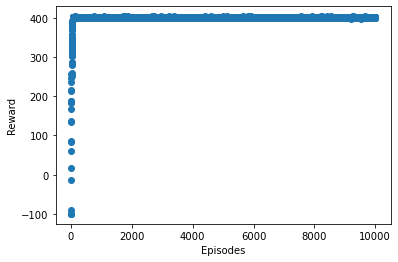

In [8]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

So now, time to graphic how the training was. There is a main value of the reward for each episode, so first we can see that it ends with a negative rate to moving around so much. But it learns so fast, and it needs less than a thousand episodes to reach a optimal reward. So there are more than 80000 episodes that are left over.

In [31]:
# Print updated Q-table
print("\n\n********Q-table********\n")
print(q_table)



********Q-table********

[[-3.14113613e+00 -3.22020507e+00 -3.09125793e+00 -3.14113613e+00]
 [-3.10534891e+00 -3.11953340e+00 -3.14954483e+00 -3.14113613e+00]
 [-2.91116297e+00 -2.82103790e+00 -2.87730068e+00 -2.79883291e+00]
 [-2.57133906e+00 -2.58674015e+00 -1.88445229e+00 -2.62508374e+00]
 [-2.35076561e+00  5.88116898e+01 -2.26283288e+00 -2.27230257e+00]
 [-1.86236037e+00 -1.74884550e+00  6.72983622e+01 -1.72965505e+00]
 [-1.27565786e+00  7.18930128e+01 -1.11940524e+00 -1.17039701e+00]
 [-9.44948043e-01 -6.89200000e-01 -7.78340000e-01 -7.88079800e-01]
 [-6.77848433e-01 -5.86800000e-01 -5.94020000e-01 -5.94020000e-01]
 [-3.14113613e+00 -3.09886345e+00 -3.01150065e+00 -3.14609648e+00]
 [-3.35118211e+00  4.96855987e+01 -3.24452008e+00 -3.32774268e+00]
 [-2.68417294e+00 -2.70916949e+00 -2.74252368e+00 -2.78196032e+00]
 [-2.36928955e+00  5.76056418e+01 -2.12618100e+00 -2.22972280e+00]
 [-1.41601971e+00 -1.48869684e+00  6.50228609e+01 -1.56724123e+00]
 [-8.17668784e-01 -8.12156600e-01  

Now, we can see how the "q_table" ends. It still has some states that doesn't prove all the moves, but it has a better move for each state. So time to simulate the situacion. 

In [10]:
import sys
from contextlib import closing

import numpy as np
from io import StringIO

from gym import utils
from gym.envs.toy_text import discrete
mapa2 = [['S','S','S','W','W','W','S','S','S'],
 ['S','H','S','W','W','W','S','S','S'],
 ['S','S','S','W','W','W','S','S','S'],
 ['S','S','S','W','W','W','S','S','S'],
 ['S','S','S','W','W','W','S','G','S'],
 ['S','S','S','W','W','W','S','S','S'],
 ['S','S','S','W','W','W','S','S','S']]
lastAction = None




In [11]:
def render(state, lastAction, mode="human"):
    outfile = StringIO() if mode == "ansi" else sys.stdout
    row = int(state/9)
    col = int(state/9)
    mapa2[row][col] = utils.colorize(mapa2[row][col], "red", highlight=True)
    if lastAction is not None:
        outfile.write(f"  ({['Left', 'Down', 'Right', 'Up'][lastAction]})\n")
    else:
        outfile.write("\n")
    outfile.write("\n".join("".join(line) for line in mapa2) + "\n")
    if mode != "human":
        with closing(outfile):
            return outfile.getvalue()

def restartRender():
    import sys
    from contextlib import closing
    import numpy as np
    from io import StringIO
    from gym import utils
    from gym.envs.toy_text import discrete
    mapa2 = [['S','S','S','W','W','W','S','S','S'],
     ['S','H','S','W','W','W','S','S','S'],
     ['S','S','S','W','W','W','S','S','S'],
     ['S','S','S','W','W','W','S','S','S'],
     ['S','S','S','W','W','W','S','G','S'],
     ['S','S','S','W','W','W','S','S','S'],
     ['S','S','S','W','W','W','S','S','S']]
    lastAction = None


First at all, i tried to use the function "render" to have a visual simulation, but i had problems to reset the simulation, and it has some troubles for been an external function, but i left the result to see how it would be.
I assigned each state a letter, having:
S - Suelo
H - Harry Potter
W - Vientos
G - Goal (Sirius)

So the simulation will moving in the map until get the goal state.

In [130]:
# render(11,None)
# render(20,1)
# render(21,2)
# render(14,2)


#render(60,2)

restartRender()
render(11,None)



SSSWWWSSS
SHSWWWSSS
SSSWWWSSS
SSSWWWSSS
SSSWWWSGS
SSSWWWSSS
SSSWWWSSS


In [12]:
pasos = []
for episode in range(5):
    restartRender()
    state = 10
    done = False
    print("*****EPISODE ", episode+1, "*****\n\n\n\n")
    time.sleep(1)
    lastAction = None
    
    for step in range(max_steps_per_episode):
        print(pasos) 
        pasos.append([int(state/9),int(state%9)])
        clear_output(wait=True)
        render(state,lastAction)
        time.sleep(0.3)
        action = np.argmax(q_table[state,:])        
        new_state = getNewState(state, action)
        if new_state == goal:
            reward = 10
            done = True
        else:
            reward = -1
        lastAction = action
        state = new_state
        if done:
            clear_output(wait=True)
            render(state, lastAction)
            print("****You reached the goal!****")
            pasos.append([-1,-1])
            time.sleep(3)
            break
        
        

  (Down)
SSSWWWSSS
SHSWWWSSS
SSSWWWSSS
SSSWWWSSS
SSSWWWSGS
SSSWWWSSS
SSSWWWSSS
****You reached the goal!****


This is the prove simulation, but how it shows, it doesn't restart the visual simulation, but it gets the goal, so i saved each step that it takes, to have an idea how Harry will move with the training. 

In [20]:
print(pasos)

[[1, 1], [2, 1], [2, 2], [1, 3], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [3, 7], [-1, -1], [1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [1, 5], [1, 6], [2, 6], [2, 7], [3, 7], [-1, -1], [1, 1], [2, 1], [2, 2], [2, 3], [0, 4], [1, 4], [1, 5], [1, 6], [2, 6], [2, 7], [3, 7], [-1, -1], [1, 1], [2, 1], [2, 2], [2, 3], [2, 4], [1, 5], [1, 6], [2, 6], [2, 7], [3, 7], [-1, -1], [1, 1], [2, 1], [2, 2], [1, 3], [1, 3], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [3, 7], [-1, -1]]


This are all the steps per episode, it doesn't count the goal step, but the coordenates of the goal state are [4,7]. So if ends with a step of [3,7], [4,6], [4,8] or [5,7]. It always will take the action to move to the goal state.

In [25]:
objetivo = [int(goal/9),int(goal%9)]
print("Coordenada objetivo: ",objetivo)

variable = 0
for i in range(5):
    print("Episodio ",i+1)
    boole = False
    for j in range(20):
        if boole == False:
            if(pasos[j+variable] != [-1,-1]):
                print("Paso ",j,":" ,pasos[j+variable])
            else:
                variable = j + 1
                boole = True
#

Coordenada objetivo:  [4, 7]
Episodio  1
Paso  0 : [1, 1]
Paso  1 : [2, 1]
Paso  2 : [2, 2]
Paso  3 : [1, 3]
Paso  4 : [2, 3]
Paso  5 : [2, 4]
Paso  6 : [2, 5]
Paso  7 : [2, 6]
Paso  8 : [2, 7]
Paso  9 : [3, 7]
Episodio  2
Paso  0 : [1, 1]
Paso  1 : [2, 1]
Paso  2 : [2, 2]
Paso  3 : [2, 3]
Paso  4 : [2, 4]
Paso  5 : [1, 5]
Paso  6 : [1, 6]
Paso  7 : [2, 6]
Paso  8 : [2, 7]
Paso  9 : [3, 7]
Episodio  3
Paso  0 : [1, 1]
Paso  1 : [2, 1]
Paso  2 : [2, 2]
Paso  3 : [2, 3]
Paso  4 : [2, 4]
Paso  5 : [1, 5]
Paso  6 : [1, 6]
Paso  7 : [2, 6]
Paso  8 : [2, 7]
Paso  9 : [3, 7]
Episodio  4
Paso  0 : [1, 1]
Paso  1 : [2, 1]
Paso  2 : [2, 2]
Paso  3 : [2, 3]
Paso  4 : [2, 4]
Paso  5 : [1, 5]
Paso  6 : [1, 6]
Paso  7 : [2, 6]
Paso  8 : [2, 7]
Paso  9 : [3, 7]
Episodio  5
Paso  0 : [1, 1]
Paso  1 : [2, 1]
Paso  2 : [2, 2]
Paso  3 : [2, 3]
Paso  4 : [2, 4]
Paso  5 : [1, 5]
Paso  6 : [1, 6]
Paso  7 : [2, 6]
Paso  8 : [2, 7]
Paso  9 : [3, 7]


So this are the steps for each episode, the are only one episode that gets push for whe wind, and is the 2nd episode, after he takes the short way to get the goal state.

In [33]:
def getBestMoves(num):
    res = ""
    if num == 0:
        res = "left"
    elif num == 1:
        res = "down"
    elif num == 3:
        res = "right"
    elif num == 4:
        res = "up"
    return res
        

for i in range(63):
    print("Optimal policy for state ",i,":", getBestMoves(np.argmax(q_table[i,:])))

# action = np.argmax(q_table[1,:]) 
# print(action)

Optimal policy for state  0 : 
Optimal policy for state  1 : left
Optimal policy for state  2 : right
Optimal policy for state  3 : 
Optimal policy for state  4 : down
Optimal policy for state  5 : 
Optimal policy for state  6 : down
Optimal policy for state  7 : down
Optimal policy for state  8 : down
Optimal policy for state  9 : 
Optimal policy for state  10 : down
Optimal policy for state  11 : left
Optimal policy for state  12 : down
Optimal policy for state  13 : 
Optimal policy for state  14 : 
Optimal policy for state  15 : down
Optimal policy for state  16 : left
Optimal policy for state  17 : 
Optimal policy for state  18 : right
Optimal policy for state  19 : 
Optimal policy for state  20 : 
Optimal policy for state  21 : 
Optimal policy for state  22 : 
Optimal policy for state  23 : 
Optimal policy for state  24 : 
Optimal policy for state  25 : down
Optimal policy for state  26 : left
Optimal policy for state  27 : 
Optimal policy for state  28 : 
Optimal policy for state

These are the best move for each state